# Brown sporophytes

In [1]:
library(sleuth)
library(splines)
library(scales)

In [2]:
library(ggplot2)

In [3]:
#https://stackoverflow.com/questions/41849951/using-ggplot-geo-geom-histogram-with-y-log-scale-with-zero-bins
mylog10_trans <- function (base = 10) 
{
  trans <- function(x) log(x + 1, base)
  inv <- function(x) base^x
  trans_new(paste0("log-", format(base)), trans, inv, log_breaks(base = base), 
            domain = c(1e-100, Inf))
}

In [4]:
d=read.delim("../gene_atlas_integration//subset.full_metadata.txt",sep="\t",stringsAsFactors=FALSE)
d$X=gsub("^ +","",gsub(" +$","",d$X))
str(d)

'data.frame':	43 obs. of  20 variables:
 $ id               : chr  "7805.1.84009.CTTGTA" "7805.1.84009.TAGCTT" "7805.2.84012.CAAAAG" "7805.3.84010.CGGAAT" ...
 $ Spike.in.mix     : chr  "A" "A" "A" "A" ...
 $ plate.coordinates: chr  "D02" "B02" "D04" "E05" ...
 $ Sample.ID        : chr  "002-F08 " "002-E02 " "002-E03 " "002-D01 " ...
 $ Plate            : int  2 2 2 2 2 2 2 2 2 2 ...
 $ Fastq.file       : chr  "7805.1.84009.CTTGTA.anqrp.fastq.gz" "7805.1.84009.TAGCTT.anqrp.fastq.gz" "7805.2.84012.CAAAAG.anqrp.fastq.gz" "7805.3.84010.CGGAAT.anqrp.fastq.gz" ...
 $ Tissue           : chr  "Protonema" "Protonema" "Protonema" "Gametophores_a" ...
 $ Condition        : chr  "Klq" "Bsl" "Bsl" "Ksl" ...
 $ Replicate        : int  2 2 3 1 3 1 4 2 5 2 ...
 $ Contributor      : chr  "Stefan Rensing" "Pierre-Francois Perroud" "Pierre-Francois Perroud" "Stefan Rensing" ...
 $ Condition.1      : chr  "protonema Knop liquid" "BCD solid" "BCD solid" "medium Knop" ...
 $ prepared.for.DEG : chr  "x" "x"

In [5]:
e=read.delim("../ENA//ena.txt",sep="\t",stringsAsFactors=FALSE)
str(e)

'data.frame':	299 obs. of  51 variables:
 $ study_accession           : chr  "PRJNA192876" "PRJNA192876" "PRJNA192876" "PRJNA192876" ...
 $ secondary_study_accession : chr  "SRP019809" "SRP019809" "SRP019809" "SRP019809" ...
 $ study_title               : chr  "Physcomitrella patens Transcriptome or Gene expression" "Physcomitrella patens Transcriptome or Gene expression" "Physcomitrella patens Transcriptome or Gene expression" "Physcomitrella patens Transcriptome or Gene expression" ...
 $ study_alias               : chr  "PRJNA192876" "PRJNA192876" "PRJNA192876" "PRJNA192876" ...
 $ experiment_accession      : chr  "SRX252526" "SRX252526" "SRX252526" "SRX252526" ...
 $ instrument_platform       : chr  "ILLUMINA" "ILLUMINA" "ILLUMINA" "ILLUMINA" ...
 $ instrument_model          : chr  "Illumina HiSeq 2000" "Illumina HiSeq 2000" "Illumina HiSeq 2000" "Illumina HiSeq 2000" ...
 $ library_name              : chr  "Physco_light" "Physco_light" "Physco_light" "Physco_light" ...
 $ library_

In [6]:
missing=c("UBYU", "UCAA","UBXS")

In [7]:
d[d$X=="","X"]=missing

In [8]:
E=merge(d,e,by.x="X",by.y="library_name")
nrow(d)
nrow(E)

[1] 43

[1] 43

In [9]:
table(E$Tissue,E$Condition,E$V5)

, ,  = development

                
                 Bsl Bsl_dehy Bsl_heat Bsl_lgt50_ABA24 BslA BslA_cont
  Gametophores     0        0        0               0    0         0
  Gametophores_a   3        0        0               0    0         0
  Protonema        2        0        0               0    0         0
  Protoplast_p     0        0        0               0    0         0
  Spores           0        0        0               0    0         3
  Sporophyte_b     0        0        0               0    0         0
  Sporophyte_g     0        0        0               0    0         0
                
                 BslA_Glc_UV-B Klq Ksl Ksl_hlgt850
  Gametophores               0   0   0           0
  Gametophores_a             0   0   3           0
  Protonema                  0   5   3           0
  Protoplast_p               0   0   0           0
  Spores                     0   0   0           0
  Sporophyte_b               0   0   3           0
  Sporophyte_g               

In [10]:
table(file.exists(sprintf("../kallisto/kallisto/%s/abundance.h5",E$run_accession)))


TRUE 
  43 

In [11]:
E$path=sprintf("../kallisto/kallisto/%s/abundance.h5",E$run_accession)

In [12]:
m=read.delim("../analysis/cosmoss_V3.3.mRNA_ncRNA.tx2gene.full.tsv",stringsAsFactors=FALSE)
names(m)[1]="target_id"
m$class=ifelse(is.na(m$class),m$TYPE,m$class)
m$gene=paste(m$GENEID,m$class,sep=".")
m=m[,c("target_id","gene","class","TYPE")]
nrow(m)
head(m)

[1] 93962

target_id,gene,class,TYPE
Pp3c1_20V3.1,Pp3c1_20.mRNA,mRNA,mRNA
Pp3c1_20V3.2,Pp3c1_20.mRNA,mRNA,mRNA
Pp3c1_40V3.2,Pp3c1_40.mRNA,mRNA,mRNA
Pp3c1_40V3.1,Pp3c1_40.mRNA,mRNA,mRNA
Pp3c1_50V3.2,Pp3c1_50.mRNA,mRNA,mRNA
Pp3c1_50V3.1,Pp3c1_50.mRNA,mRNA,mRNA


In [13]:
D=droplevels(subset(E, V5=="development")[,c("run_accession","Tissue","Condition","V5","X","path")])
D$is_target_tissue=factor(D$Tissue=="Sporophyte_b",levels=c("FALSE","TRUE"))
D$sample=D$run_accession
nrow(D)
nrow(E)
head(D)
table(D$is_target_tissue)

[1] 25

[1] 43

run_accession,Tissue,Condition,V5,X,path,is_target_tissue,sample
SRR1588478,Protonema,Klq,development,SYYC,../kallisto/kallisto/SRR1588478/abundance.h5,FALSE,SRR1588478
SRR1588458,Protonema,Ksl,development,SYYH,../kallisto/kallisto/SRR1588458/abundance.h5,FALSE,SRR1588458
SRR1588472,Protonema,Ksl,development,SYYN,../kallisto/kallisto/SRR1588472/abundance.h5,FALSE,SRR1588472
SRR1588461,Gametophores_a,Ksl,development,SYYP,../kallisto/kallisto/SRR1588461/abundance.h5,FALSE,SRR1588461
SRR1588457,Gametophores_a,Bsl,development,SYYS,../kallisto/kallisto/SRR1588457/abundance.h5,FALSE,SRR1588457
SRR1588462,Gametophores_a,Ksl,development,SYYT,../kallisto/kallisto/SRR1588462/abundance.h5,FALSE,SRR1588462



FALSE  TRUE 
   22     3 

In [14]:
so.D=sleuth_prep(sample_to_covariates=D, 
                 target_mapping = m,extra_bootstrap_summary = TRUE,aggregation_column="gene",gene_mode = TRUE)

'gene_mode' is TRUE. Sleuth will do counts aggregation at the gene level for downstream normalization, transformation, and modeling steps, as well as for plotting and results.
reading in kallisto results
dropping unused factor levels
.........................
normalizing est_counts
48016 targets passed the filter
normalizing tpm
merging in metadata
aggregating by column: gene
21935 genes passed the filter
Warning message in sleuth_prep(sample_to_covariates = D, target_mapping = m, extra_bootstrap_summary = TRUE, :
“2 target_ids are missing annotations for the aggregation_column: gene.
These target_ids will be dropped from the gene-level analysis.
If you did not expect this, check your 'target_mapping' table for missing values.”summarizing bootstraps



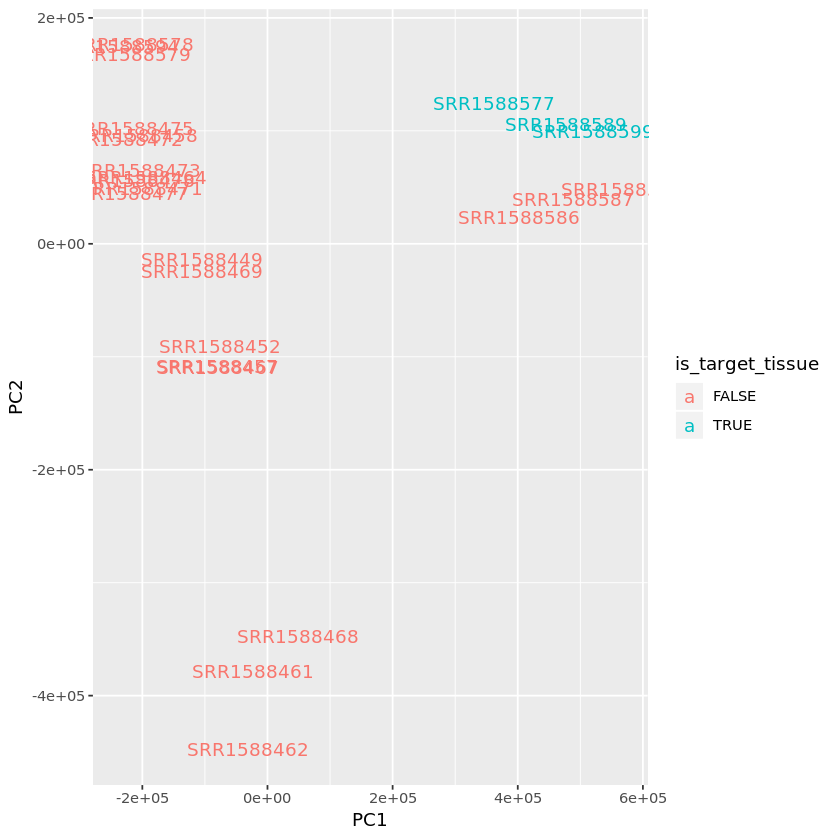

In [15]:
plot_pca(so.D, color_by = 'is_target_tissue',text_labels = TRUE,units='scaled_reads_per_base')

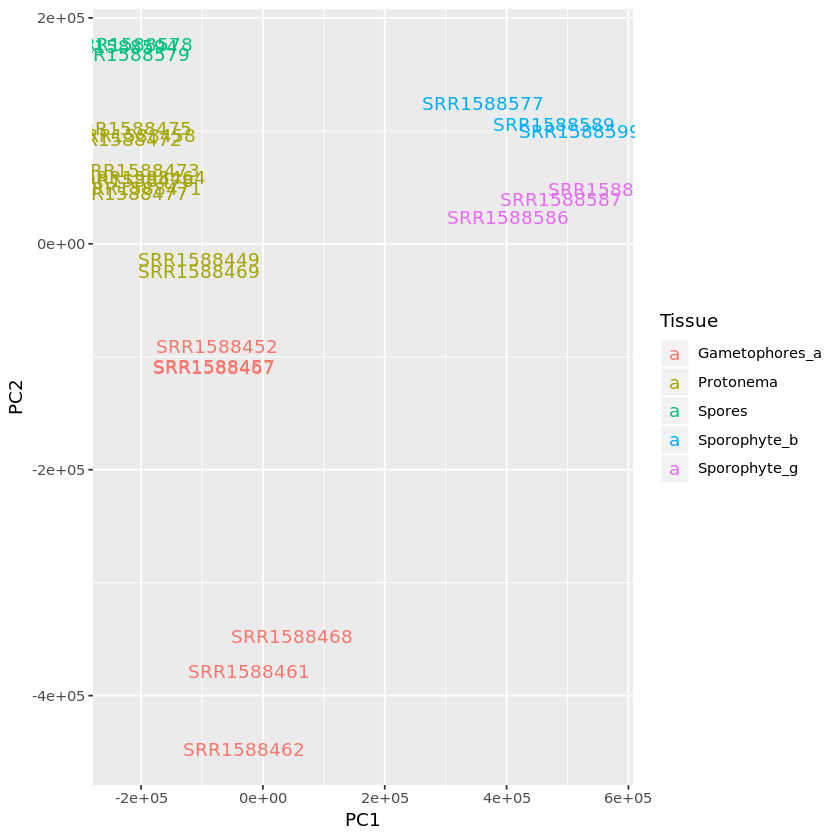

In [16]:
plot_pca(so.D, color_by = 'Tissue',text_labels = TRUE,units='scaled_reads_per_base')

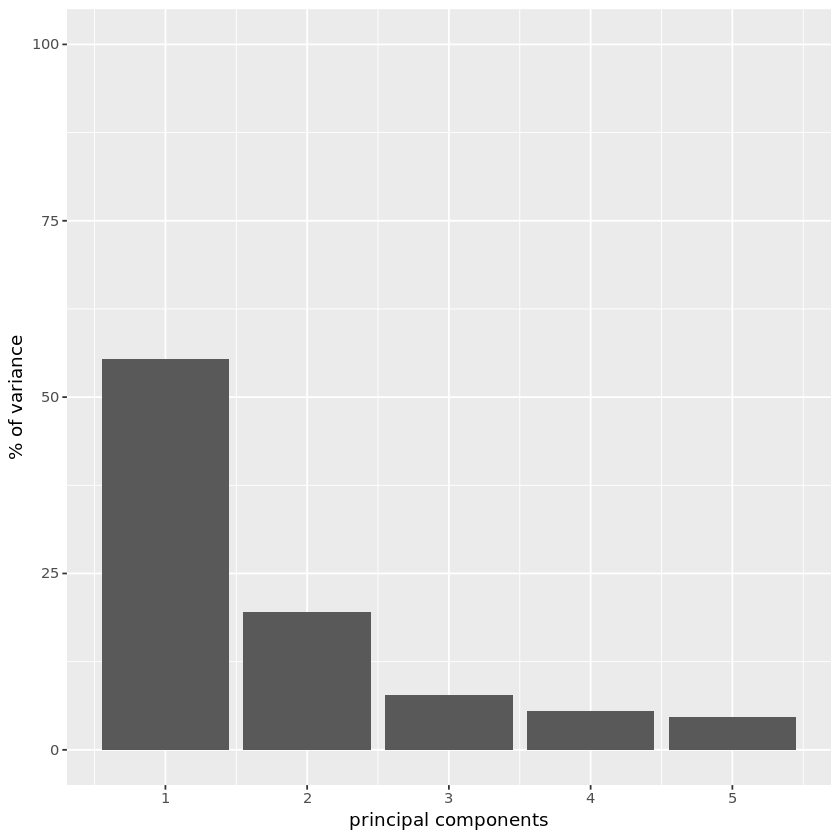

In [17]:
plot_pc_variance(so.D,units='scaled_reads_per_base')

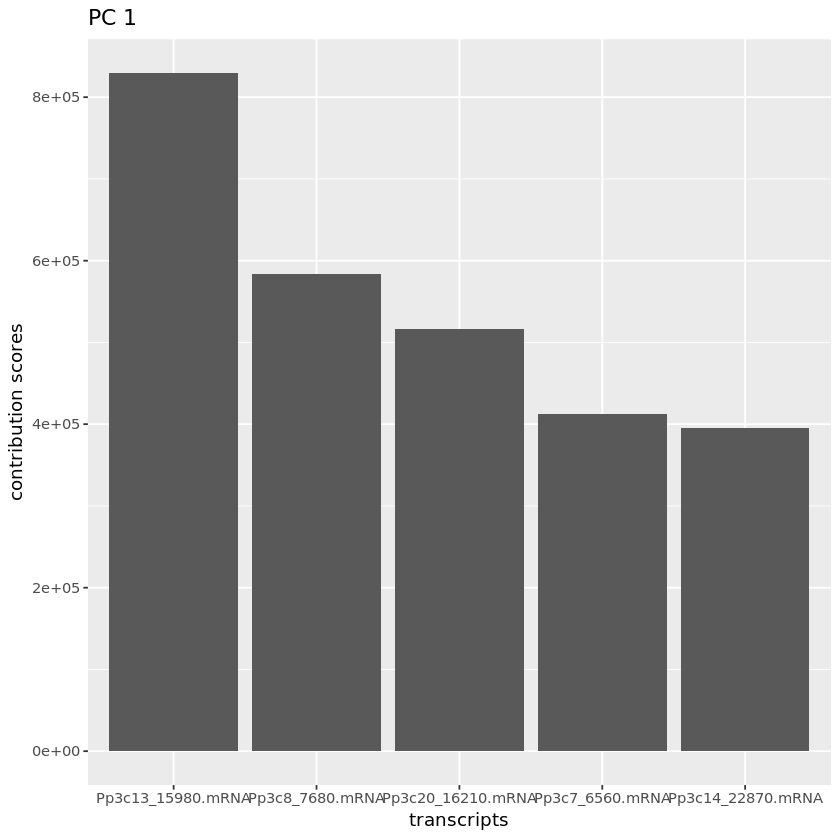

In [18]:
plot_loadings(so.D, pc_input = 1,units='scaled_reads_per_base')

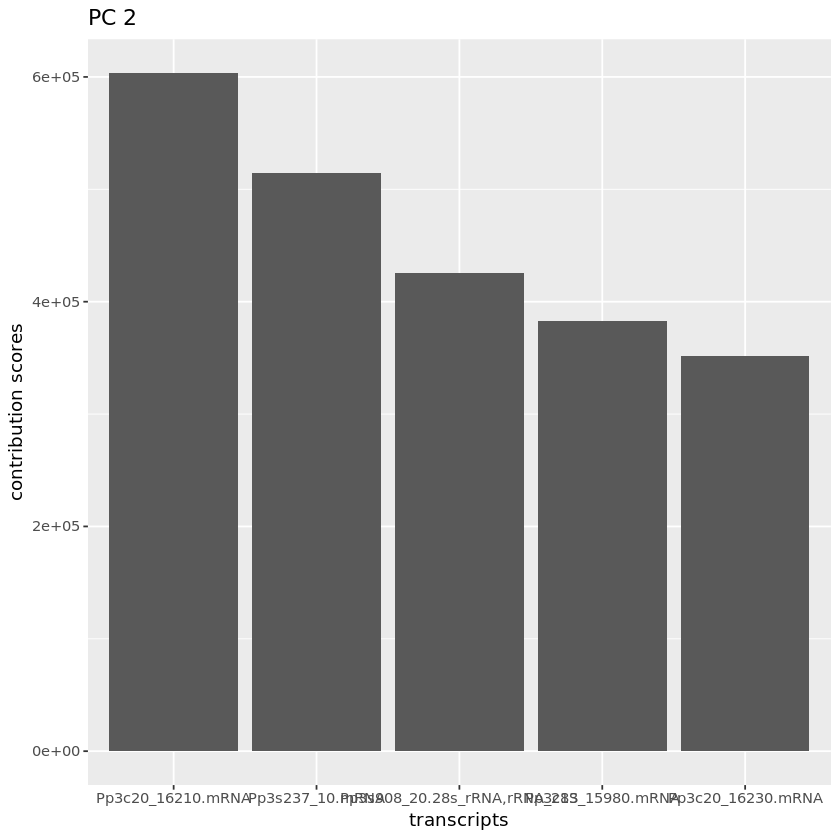

In [19]:
plot_loadings(so.D, pc_input = 2,units='scaled_reads_per_base')

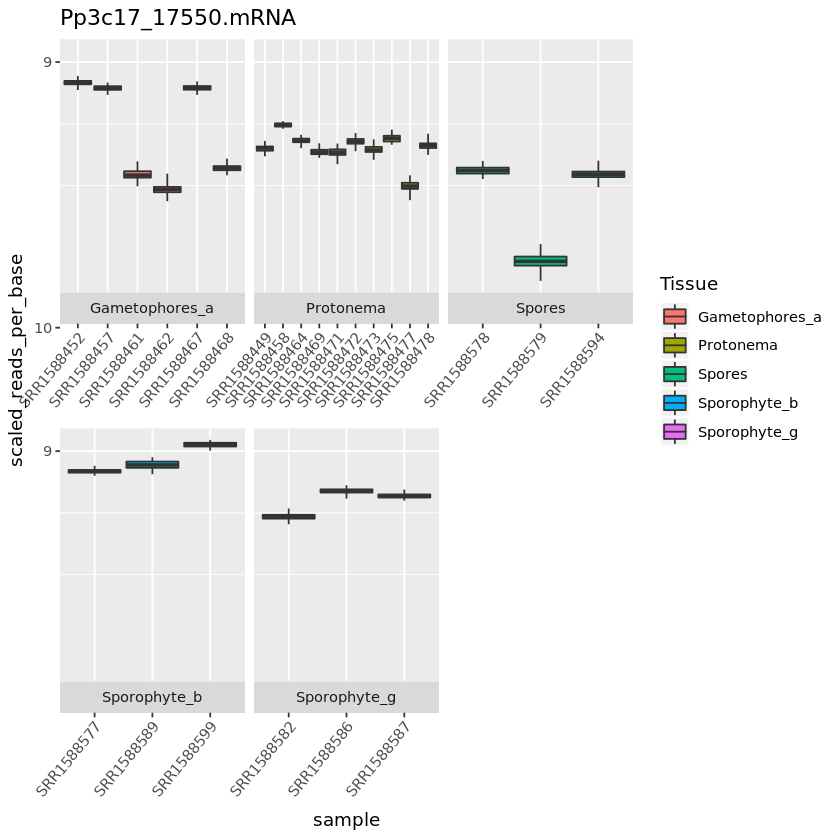

In [20]:
plot_bootstrap(so.D, 'Pp3c17_17550.mRNA', color_by = 'Tissue',units='scaled_reads_per_base') + scale_y_continuous(trans = "mylog10")

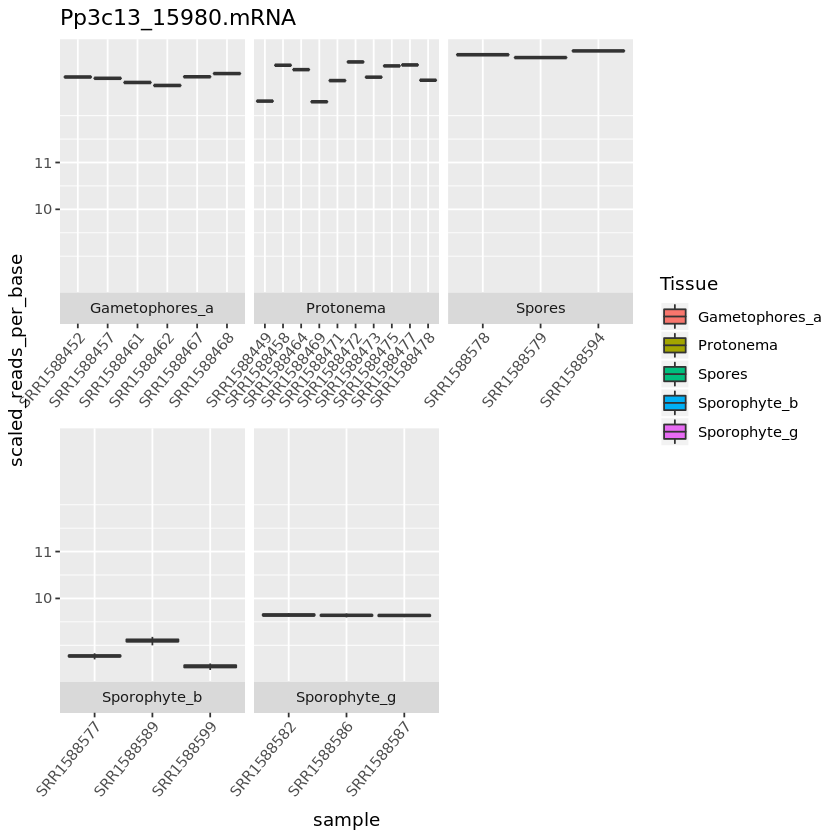

In [21]:
plot_bootstrap(so.D, 'Pp3c13_15980.mRNA', color_by = 'Tissue',units='scaled_reads_per_base') + scale_y_continuous(trans = "mylog10")

In [22]:
full_design = model.matrix(formula(~ is_target_tissue),data=D)
reduced_design = model.matrix(formula(~ 1),data=D)

In [23]:
full_design

,(Intercept),is_target_tissueTRUE
1,1,0
2,1,0
3,1,0
4,1,0
5,1,0
6,1,0
7,1,0
8,1,0
9,1,0
10,1,0


In [24]:
so.D= sleuth_fit(so.D,reduced_design,fit_name="reduced")

fitting measurement error models
shrinkage estimation
computing variance of betas


In [25]:
so.D= sleuth_fit(so.D, full_design, fit_name = "full")

fitting measurement error models
shrinkage estimation
computing variance of betas


In [26]:
so.D = sleuth_lrt(so.D, "reduced", "full")

In [27]:
models(so.D)

[  reduced  ]
formula:  structure(c(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,  1, 1, 1, 1, 1, 1, 1, 1), .Dim = c(25L, 1L), .Dimnames = list(     c("1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11",      "12", "13", "14", "15", "16", "18", "19", "21", "25", "27",      "31", "33", "35", "37"), "(Intercept)"), assign = 0L) 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
[  full  ]
formula:  structure(c(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,  1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1), .Dim = c(25L, 2L), .Dimnames = list(     c("1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11",      "12", "13", "14", "15", "16", "18", "19", "21", "25", "27",      "31", "33", "35", "37"), c("(Intercept)", "is_target_tissueTRUE"     )), assign = 0:1, contrasts = list(is_target_tissue = "contr.treatment")) 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	

In [28]:
so.D = sleuth_wt(so.D, 'is_target_tissueTRUE', which_model = "full")

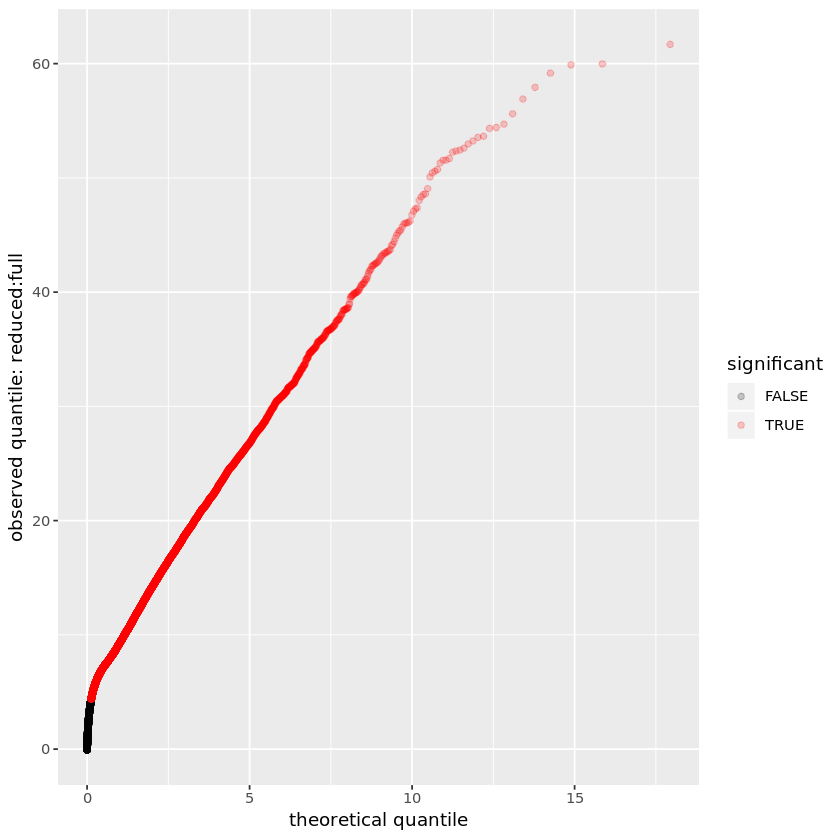

In [29]:
plot_qq(so.D, test = 'reduced:full', test_type = 'lrt', sig_level = 0.05)

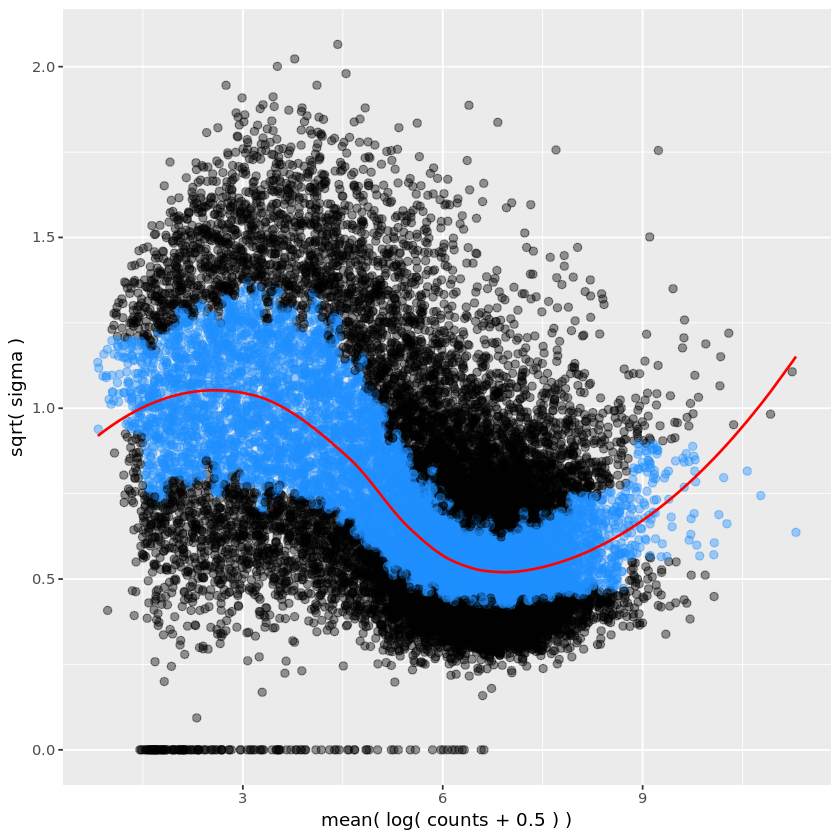

In [30]:
plot_mean_var(so.D,which_model="full")

In [31]:
tt=sleuth_results(so.D,'is_target_tissueTRUE','wt',which_model="full" ,show_all = FALSE,rename_cols=FALSE)
tt.sig= dplyr::filter(tt, qval < 0.05)
nrow(tt.sig)
table(tt.sig$b>0)

[1] 8962


FALSE  TRUE 
 5063  3899 

In [32]:
lrt_results= sleuth_results(so.D, 'reduced:full', test_type = 'lrt',show_all=TRUE)

In [33]:
o=na.omit(merge(lrt_results,tt,by="target_id",suffixes=c(".lrt",".wt")))
o=o[order(-o$b,-o$test_stat),]
table(o$b>0)
head(o[o$b>0,])


FALSE  TRUE 
11045 10890 

,target_id,class.lrt,TYPE.lrt,pval.lrt,qval.lrt,test_stat,rss,degrees_free,mean_obs.lrt,var_obs.lrt,⋯,pval.wt,qval.wt,b,se_b,mean_obs.wt,var_obs.wt,sigma_q_sq,sigma_sq.wt,smooth_sigma_sq.wt,smooth_sigma_sq_pmax
4575,Pp3c14_10090.mRNA,mRNA,mRNA,8.791169e-05,0.0006616851,15.38005,465.1368,1,3.455909,19.38070,⋯,9.253021e-06,7.915952e-05,9.010901,2.032260,3.455909,19.38070,0.10674341,10.796669,1.0709500,10.796669
7551,Pp3c17_20120.mRNA,mRNA,mRNA,7.657910e-05,0.0005967185,15.64093,360.4084,1,3.616041,15.01702,⋯,7.321907e-06,6.463020e-05,7.979884,1.779592,3.616041,15.01702,0.15067124,8.210069,1.0047973,8.210069
17349,Pp3c5_1060.mRNA,mRNA,mRNA,9.647364e-04,0.0038978620,10.89405,429.7939,1,3.962330,17.90808,⋯,3.750883e-04,1.780858e-03,7.600987,2.136898,3.962330,17.90808,0.18185376,11.873271,0.8384916,11.873271
18601,Pp3c6_2090.mRNA,mRNA,mRNA,7.670888e-05,0.0005973054,15.63772,320.7626,1,3.665778,13.36511,⋯,7.343074e-06,6.476490e-05,7.527646,1.678969,3.665778,13.36511,0.17536590,7.266626,0.9824660,7.266626
10003,Pp3c2_29970.mRNA,mRNA,mRNA,1.466902e-04,0.0009656812,14.41422,334.5874,1,2.546866,13.94114,⋯,2.159599e-05,1.632913e-04,7.464287,1.757247,2.546866,13.94114,0.06734301,8.084756,1.2271197,8.084756
19896,Pp3c7_6750.mRNA,mRNA,mRNA,1.885369e-04,0.0011565537,13.94201,339.8111,1,5.286405,14.15879,⋯,3.233905e-05,2.285091e-04,7.430346,1.787715,5.286405,14.15879,0.08959619,8.347645,0.2319480,8.347645


In [34]:
m1=read.delim("../analysis//cosmoss_V3.3.mRNA_ncRNA.tx2gene.full.gene_wise.tsv",sep="\t",stringsAsFactors=FALSE)
names(m1)[1]="target_id"
head(m1)

target_id,spectype,TXNAME,GENEID,TYPE,Alias,support,origin,isoform,longest_transcript,has_evidence,class,has_protein_homology,has_proteomics_support,encoded_by,is_filtered
Pp3c10_10000.tRNA,tRNA,Pp3c10_10000V3.1,Pp3c10_10000,ncRNA,"tRNA,Pp3c10_10000N1.1,Pp3c10_10000V1.1,N1.Chr10.ncRNA.54,tRNA.717",supported_by_sequence_similarity,RFAM11.Infernal1.1,major,true,false,tRNA,false,false,ncRNA_gene,false
Pp3c10_10040.mRNA,mRNA,"Pp3c10_10040V3.2,Pp3c10_10040V3.3,Pp3c10_10040V3.5,Pp3c10_10040V3.6,Pp3c10_10040V3.4,Pp3c10_10040V3.1",Pp3c10_10040,mRNA,"PAC4GC:5701563,Pp3c10_10040J4.1,Pp1s58_283V6.2,PAC4GC:5701564,P2.evm.model.Chr10.357,Pp3c10_10040J5.3,Pp3c10_10040J5.4,Pp3c10_10040V1.1,P2.Chr10.mRNA.3452,Phpatv32029367m,PAC4GC:5701565,Phpatv32029366m,PAC4GC:5701561,Pp3c10_10040J5.2,Pp1s58_283V6.1,Pp3c10_10040J5.1,Phpatv32029364m,Pp3c10_10040P2.1,Phpatv32029365m,Phpatv32029363m,P2.EVM%20prediction%20Chr10.357,Pp3c10_10040P2.2,PAC4GC:5701562",supported_by_EST_or_cDNA,NA,"alternative,major","true,false",true,NA,true,false,protein_coding_gene,false
Pp3c10_10090.mRNA,mRNA,"Pp3c10_10090V3.2,Pp3c10_10090V3.1",Pp3c10_10090,mRNA,"Phpatv32029368m,Pp3c10_10090V1.1,J3.Chr10.mRNA.912,J3.Phypav3.0.4_pg25522.valid.m1,J3.7022241,Pp3c10_10090J4.1,Pp3c10_10090J3.1,PAC4GC:5700224,pred.234120000946",supported_by_EST_or_cDNA,NA,"major,alternative","false,true",true,NA,false,false,protein_coding_gene,false
Pp3c10_10095.C_D_box_snoRNA,C_D_box_snoRNA,Pp3c10_10095V3.1,Pp3c10_10095,ncRNA,"Chr10.snoRNA.21,snoR64.1,Chr10.snoRNA.22,Pp3c10_10095V1.1,Chr10.snoRNA.32,Chr10.snoRNA.23,snoR64,N1.Chr10.ncRNA.55,Pp3c10_10095N1.1,Chr10.snoRNA.33,snR72%2FZ2,snR58",supported_by_sequence_similarity,"RFAM11.Infernal1.1,snoscan-0.9b",major,true,true,C_D_box_snoRNA,false,false,ncRNA_gene,false
Pp3c10_100.ncRNA,ncRNA,Pp3c10_100V3.1,Pp3c10_100,ncRNA,"Pp3c10_100V1.1,Pp3c10_100P0.1,asmbl_110854",supported_by_EST_or_cDNA,NA,major,true,true,NA,false,false,ncRNA_gene,false
Pp3c10_10100.mRNA,mRNA,"Pp3c10_10100V3.1,Pp3c10_10100V3.4,Pp3c10_10100V3.2,Pp3c10_10100V3.5,Pp3c10_10100V3.3",Pp3c10_10100,mRNA,"Pp3c10_10100J5.3,Phpatv32029369m,PAC4GC:5701591,PAC4GC:5701593,Pp1s58_289V6.1_29440,PAC4GC:5701592,Phpatv32029370m,Pp3c10_10100V1.1,Phpatv32029372m,Pp3c10_10100J5.1,Pp3c10_10100J5.2,C1.Pp1s58_289V6.1,Phpatv32029371m,C1.560145,PAC4GC:5701590,Pp1s58_289V6.1,C1.Chr10.mRNA.576,Pp3c10_10100J4.1,Pp3c10_10100C1.1",supported_by_EST_or_cDNA,NA,"alternative,major","true,false",true,NA,true,false,protein_coding_gene,false


In [35]:
m2=read.delim("../analysis//cosmoss.genonaut.V3.3.gene_and_protein_names.tsv",sep="\t",col.names=c("GENEID","name"),stringsAsFactors=FALSE)
head(m2)

GENEID,name
Pp3c10_13310,XTH28
Pp3c10_13800,"chr1545,CHR1545"
Pp3c10_13960,"CHLH1,CHLH2,chlh2,chlh1"
Pp3c10_13970,"chlh1,chlh2,CHLH2,CHLH1"
Pp3c10_14020,"RABA53,raba53"
Pp3c10_14800,"PPR_20,ppr_20"


In [36]:
m3=read.delim("../analysis//Ppatens_318_v3.3.defline.txt",sep="\t",col.names=c("GENEID","source","defline"),stringsAsFactors=FALSE)
m3$GENEID=gsub("V3\\.\\d+","",m3$GENEID,perl=TRUE)
head(m3)

GENEID,source,defline
Pp3c10_10220,pdef,"K00615 - transketolase (E2.2.1.1, tktA, tktB) (1 of 4)"
Pp3c10_10230,pdef,K14763 - H/ACA ribonucleoprotein complex non-core subunit NAF1 (NAF1) (1 of 1)
Pp3c10_10240,pdef,PTHR10641:SF599 - MYB TRANSCRIPTION FACTOR-RELATED (1 of 3)
Pp3c10_10270,pdef,2.4.1.12 - Cellulose synthase (UDP-forming) / UDP-glucose-cellulose glucosyltransferase (1 of 17)
Pp3c10_10460,pdef,"K03320 - ammonium transporter, Amt family (amt, AMT, MEP) (1 of 12)"
Pp3c10_10490,pdef,"PTHR11177:SF167 - RHODANESE-LIKE DOMAIN-CONTAINING PROTEIN 4, CHLOROPLASTIC (1 of 3)"


In [37]:
m4=read.delim("../analysis//Physcomitrella_patens.TAP_annotation.6.tsv",sep="\t")
names(m4)[2]="GENEID"
head(m4)

superfamily,GENEID,inferred_by_rule,TAP_class
BSD domain containing,Pp3c11_12590V3,True,PT
BSD domain containing,Pp3c1_21290V3,True,PT
BSD domain containing,Pp3c20_12230V3,True,PT
BSD domain containing,Pp3c23_10600V3,True,PT
BSD domain containing,Pp3c24_7080V3,True,PT
BSD domain containing,Pp3c26_14480V3,True,PT


In [38]:
O=merge(o,m1,by="target_id")
nrow(o)
nrow(O)
O=merge(O,m2,by="GENEID",all.x=TRUE)
nrow(O)
O=merge(O,m3,by="GENEID",all.x=TRUE)
nrow(O)
O=merge(O,m4,by="GENEID",all.x=TRUE)
nrow(O)
O=O[order(-O$test_stat),]
head(O)

[1] 21935

[1] 21935

[1] 21935

[1] 21935

[1] 21935

,GENEID,target_id,class.lrt,TYPE.lrt,pval.lrt,qval.lrt,test_stat,rss,degrees_free,mean_obs.lrt,⋯,has_protein_homology,has_proteomics_support,encoded_by,is_filtered,name,source,defline,superfamily,inferred_by_rule,TAP_class
5877,Pp3c15_21520,Pp3c15_21520.mRNA,mRNA,mRNA,4.029411e-15,7.306811e-11,61.68548,115.02982,1,5.258989,⋯,true,false,protein_coding_gene,false,NA,pdef,K05868 - cyclin B (CCNB) (1 of 2),NA,NA,NA
7657,Pp3c17_2240,Pp3c17_2240.mRNA,mRNA,mRNA,9.588587e-15,7.306811e-11,59.97877,14.44777,1,7.446384,⋯,true,true,protein_coding_gene,false,NA,pdef,PTHR32116:SF4 - POLYGALACTURONATE 4-ALPHA-GALACTURONOSYLTRANSFERASE-RELATED (1 of 5),NA,NA,NA
7783,Pp3c17_5100,Pp3c17_5100.mRNA,mRNA,mRNA,9.993359e-15,7.306811e-11,59.89740,52.44620,1,5.406273,⋯,true,false,protein_coding_gene,false,NA,pdef,K10400 - kinesin family member 15 (KIF15) (1 of 7),NA,NA,NA
18303,Pp3c6_12520,Pp3c6_12520.mRNA,mRNA,mRNA,1.441307e-14,7.903767e-11,59.17670,143.13387,1,5.476099,⋯,true,true,protein_coding_gene,false,NA,pdef,"K06688 - ubiquitin-conjugating enzyme E2 C (UBE2C, UBC11) (1 of 1)",NA,NA,NA
18538,Pp3c6_19200,Pp3c6_19200.mRNA,mRNA,mRNA,2.722172e-14,1.194217e-10,57.92563,44.30927,1,5.720515,⋯,true,false,protein_coding_gene,false,NA,pdef,PTHR27001:SF10 - RECEPTOR-LIKE SERINE/THREONINE-PROTEIN KINASE ALE2 (1 of 8),NA,NA,NA
373,Pp3c1_21300,Pp3c1_21300.mRNA,mRNA,mRNA,4.580877e-14,1.674692e-10,56.90197,67.80647,1,5.957526,⋯,true,"true,false",protein_coding_gene,false,NA,NA,NA,NA,NA,NA


In [39]:
t(O[ O$target_id=='Pp3c17_17550.mRNA',])

,7456
GENEID,Pp3c17_17550
target_id,Pp3c17_17550.mRNA
class.lrt,mRNA
TYPE.lrt,mRNA
pval.lrt,0.002553018
qval.lrt,0.007833326
test_stat,9.102203
rss,2.55658
degrees_free,1
mean_obs.lrt,7.448226


In [40]:
table(o$qval.lrt<0.05)
table(o$qval.wt<0.05)
table(o$qval.lrt<0.05,o$qval.wt<0.05)


FALSE  TRUE 
 6160 15775 


FALSE  TRUE 
12973  8962 

       
        FALSE TRUE
  FALSE  6160    0
  TRUE   6813 8962

In [41]:
table(o$qval.lrt<0.05 ,o$b>0)

       
        FALSE TRUE
  FALSE  2850 3310
  TRUE   8195 7580

In [42]:
head(O[O$b>0,c("target_id","test_stat","b","qval.lrt","qval.wt","name","superfamily","TAP_class","defline")],n=50)

,target_id,test_stat,b,qval.lrt,qval.wt,name,superfamily,TAP_class,defline
20761,Pp3c8_820.mRNA,52.42798,1.936458,5.955579e-10,1.184260e-24,NA,NA,NA,PTHR21212 - BERNARDINELLI-SEIP CONGENITAL LIPODYSTROPHY 2 HOMOLOG BSCL2 PROTEIN (1 of 3)
20613,Pp3c8_3810.mRNA,46.10992,2.864929,6.528018e-09,1.110066e-25,NA,NA,NA,2.1.1.77 - Protein-L-isoaspartate(D-aspartate) O-methyltransferase / Protein L-isoaspartyl methyltransferase (1 of 8)
12557,Pp3c23_10040.mRNA,44.70140,1.813329,1.094334e-08,7.923768e-23,NA,NA,NA,"K02971 - small subunit ribosomal protein S21e (RP-S21e, RPS21) (1 of 5)"
3959,Pp3c13_13320.mRNA,44.41500,1.575661,1.239767e-08,1.017063e-16,NA,NA,NA,PTHR31140:SF1 - B3 DOMAIN-CONTAINING TRANSCRIPTION FACTOR ABI3 (1 of 9)
13987,Pp3c25_14360.mRNA,43.41760,1.518544,1.766739e-08,3.857949e-17,NA,NA,NA,PTHR23092:SF15 - LP06848P-RELATED (1 of 2)
17715,Pp3c5_21420.mRNA,42.70285,1.353382,2.291287e-08,8.338682e-14,NA,NA,NA,PTHR24423//PTHR24423:SF524 - TWO-COMPONENT SENSOR HISTIDINE KINASE // SUBFAMILY NOT NAMED (1 of 5)
15355,Pp3c3_17110.mRNA,42.54863,2.386471,2.400550e-08,1.289161e-21,NA,NA,NA,PF00847 - AP2 domain (AP2) (1 of 150)
17838,Pp3c5_25280.mRNA,42.28193,1.230957,2.565824e-08,1.863387e-11,NA,NA,NA,NA
7260,Pp3c17_12870.mRNA,42.26903,1.484469,2.565824e-08,2.006188e-16,NA,NA,NA,PTHR22884:SF340 - HISTONE-LYSINE N-METHYLTRANSFERASE SU(VAR)3-9-RELATED (1 of 4)
4302,Pp3c13_23600.mRNA,40.82154,1.723446,4.690278e-08,7.226352e-20,NA,NA,NA,KOG3576 - Ovo and related transcription factors (1 of 1)


In [43]:
plot_transcript_heatmap(so.D, head(O, n = 25)$target_id)

In [44]:
subset(O,spectype=="pre_miRNA" & qval.lrt<0.1)[,c("target_id","test_stat","b","qval.lrt","qval.wt","Alias")]

,target_id,test_stat,b,qval.lrt,qval.wt,Alias
4480,Pp3c13_7201.pre_miRNA,6.733299,0.2173948,0.01810779,0.73101650,"MI0005966,Pp3c13_7201V1.1,ppt-MIR1025,Pp3c13_7201N1.1,N1.Chr13.ncRNA.30"
13798,Pp3c24_7848.pre_miRNA,6.655079,-1.8169768,0.01865628,0.02252610,"Pp3c24_7848V1.1,N1.Chr24.ncRNA.42,Pp3c24_7848N1.1,MI0005932,ppt-MIR536d"
20731,Pp3c8_7462.pre_miRNA,5.374420,-2.3366178,0.03166757,0.04526022,"ppt-MIR1049,Pp3c8_7462V1.1,N1.Chr08.ncRNA.35,Pp3c8_7462N1.1,MI0006008"
14740,Pp3c26_8063.pre_miRNA,5.223485,1.5249312,0.03388066,0.06755839,"Pp3c26_8063N1.1,MI0005994,N1.Chr26.ncRNA.62,ppt-MIR1035,Pp3c26_8063V1.1"
12306,Pp3c22_2794.pre_miRNA,4.787410,0.1831641,0.04144739,0.83273740,"MI0003499,Pp3c22_2794N1.1,MIR159.3,ppt-MIR319d,Pp3c22_2794V1.1,N1.Chr22.ncRNA.13,MIR159"
9475,Pp3c2_15903.pre_miRNA,4.776448,1.1545137,0.04165191,0.18199266,"MI0006006,Pp3c2_15903V1.1,ppt-MIR1047,N1.Chr02.ncRNA.77,Pp3c2_15903N1.1"
18296,Pp3c6_12422.pre_miRNA,4.254379,-0.1177649,0.05366471,0.83934765,"Pp3c6_12422N1.1,N1.Chr06.ncRNA.71,ppt-MIR419,Pp3c6_12422V1.1,MI0005670"
7727,Pp3c17_2572.pre_miRNA,3.138371,-0.1717318,0.09605844,0.87474328,"MI0006015,N1.Chr17.ncRNA.13,Pp3c17_2572V1.1,ppt-MIR1056,Pp3c17_2572N1.1"


In [ ]:
write.table(o,gzfile("gene_atlas/brown_sporophytes.dge.tsv.gz"),sep="\t",col.names=TRUE,row.names=FALSE,quote=FALSE)
write.table(O,gzfile("gene_atlas/brown_sporophytes.dge.full.tsv.gz"),sep="\t",col.names=TRUE,row.names=FALSE,quote=FALSE)